# Quick Start With TciaDataset

In this tutorial, we introduce how to use `TciaDataset` to automatically download and extract  
the TCIA datasets, and act as PyTorch datasets to generate training/validation/test data.

We'll cover the following topics in this tutorial:
* Access a dataset(collection) from TCIA with TciaDataset
* Visualize images and masks from the dataset

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, pillow, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import matplotlib" || pip install -q pydicom

In [2]:
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    ResampleToMatchd,
)
import monai
from monai.data import DataLoader
from monai.apps.datasets import TciaDataset
from monai.config import print_config
import os
import tempfile
import shutil

## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0+unknown
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: None
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpq6c21xuf


## Create TciaDataset

There are many collections on the [TCIA website](https://www.cancerimagingarchive.net/collections/). `TciaDataset` inherits from MONAI `CacheDataset` and provides rich parameters to achieve expected behavior. Some of the main parameters include:
1. **root_dir**: target directory to download and load TCIA dataset.
1. **collection**: name of collection (dataset)
1. **download**: whether to download and extract the dataset first.
1. **download_len**: number of series that will be downloaded. Sometimes only download a few series is enough. If not specified, the whole dataset will be downloaded.
1. **seg_type**: modality type of segmentation that is used to do the first step download (two steps download will be introduced bellow)
1. **modality_tag**: tag of modality.
1. **ref_series_uid_tag**: tag of referenced Series Instance UID.
1. **ref_sop_uid_tag**: tag of referenced SOP Instance UID.

After downloading (if specified, all images and "seg_type" data (such as "SEG", "RTSTRUCT") will be stored locally for further usage.

<p align="center">
  <img src="../figures/tcia_download_steps.png" alt="tcia download steps">
</p>

In [5]:
# use the `LoadImaged` transform to load data

transform = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"]),
    ]
)

In [ ]:
# Let's take the "NSCLC-Radiomics" collection for example
collection, seg_type = "NSCLC-Radiomics", "SEG"

ds = TciaDataset(
    root_dir=root_dir,
    collection=collection,
    section="training",
    download=True,
    download_len=2,
    seg_type=seg_type,
    progress=True,
    cache_rate=1.0,
    val_frac=0.0,
    transform=transform,
)

### Detect dataset

In [7]:
ds.datalist

[{'image': '/tmp/tmpq6c21xuf/NSCLC-Radiomics/LUNG1-005/300/image',
  'seg': '/tmp/tmpq6c21xuf/NSCLC-Radiomics/LUNG1-005/300/seg'},
 {'image': '/tmp/tmpq6c21xuf/NSCLC-Radiomics/LUNG1-001/300/image',
  'seg': '/tmp/tmpq6c21xuf/NSCLC-Radiomics/LUNG1-001/300/seg'}]

In [8]:
sample = 0

ds[sample]["image"].affine

tensor([[ -0.9770,   0.0000,   0.0000, 250.1120],
        [  0.0000,  -0.9770,   0.0000, 250.1120],
        [  0.0000,   0.0000,  -3.0000,  90.6000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)

In [9]:
ds[sample]["seg"].affine

tensor([[  -0.9770,    0.0000,    0.0000,  250.1120],
        [   0.0000,   -0.9770,    0.0000,  250.1120],
        [   0.0000,    0.0000,    3.0000, -179.4000],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)

In [10]:
print(ds[sample]["image"].shape, ds[sample]["seg"].shape)

(512, 512, 91) (512, 512, 91, 6)


As we can see from the metadata, the affine matrixes between images and segmentations have some differences: the direction of the third spatial dimension is opposite.

We can use the `ResampleToMatchd` transform to unify them.
In addition, images do not have the channel dimension, and the channel dimension of segmentations can be adjusted into the first dimension. We can use the `EnsureChannelFirstd` to address this issue

### Add pre-processing transforms and reload

In [ ]:
transform = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image", "seg"]),
        ResampleToMatchd(keys="image", key_dst="seg"),
    ]
)

ds = TciaDataset(
    root_dir=root_dir,
    collection=collection,
    section="training",
    download=False,
    download_len=2,
    seg_type=seg_type,
    progress=True,
    cache_rate=1.0,
    val_frac=0.0,
    transform=transform,
)

In [12]:
sample = 0

ds[sample]["image"].affine

tensor([[  -0.9770,    0.0000,    0.0000,  250.1120],
        [   0.0000,   -0.9770,    0.0000,  250.1120],
        [   0.0000,    0.0000,    3.0000, -179.4000],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)

In [13]:
ds[sample]["seg"].affine

tensor([[  -0.9770,    0.0000,    0.0000,  250.1120],
        [   0.0000,   -0.9770,    0.0000,  250.1120],
        [   0.0000,    0.0000,    3.0000, -179.4000],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)

In [14]:
print(ds[sample]["image"].shape, ds[sample]["seg"].shape)

(1, 512, 512, 91) (6, 512, 512, 91)


As we can see, now the affine matrixes for images and segmentations are identical.

## Visualize and check

In [21]:
# from W, H, D to D, H, W
img = ds[sample]["image"].numpy().transpose([0, 3, 2, 1])
seg = ds[sample]["seg"].numpy().transpose([0, 3, 2, 1])

In [22]:
ds[sample]["seg_meta_dict"]["labels"]

{'0': 'Esophagus',
 '1': 'GTV-1',
 '2': 'Heart',
 '3': 'Lung-Left',
 '4': 'Lung-Right',
 '5': 'Spinal-Cord'}

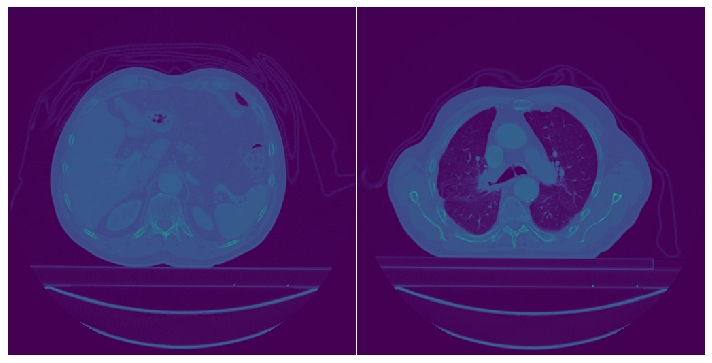

In [23]:
every_n = 50
fig_img = monai.visualize.matshow3d(img, show=True, every_n=every_n)

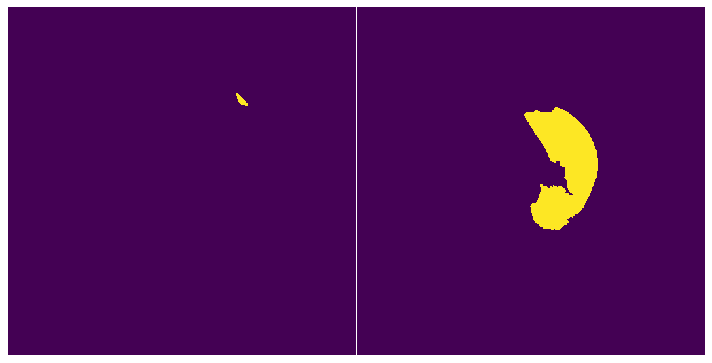

In [24]:
fig_seg = monai.visualize.matshow3d(seg[3], show=True, every_n=every_n)

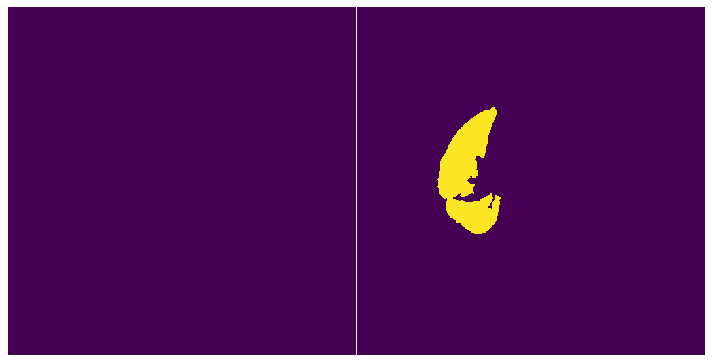

In [25]:
fig_seg = monai.visualize.matshow3d(seg[4], show=True, every_n=every_n)

## Cleanup data directory

Remove directory if a temporary was used.

In [26]:
if directory is None:
    shutil.rmtree(root_dir)